# Time Series stock price forcasting with LSTM

## Loading the required libraries

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import CSVLogger
from datetime import datetime
%matplotlib inline

Using TensorFlow backend.


## Loading and exploring the stock data

In [2]:
df = pd.read_csv('TSLA2.csv')

# A quick check on dataframe structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1446 entries, 0 to 1445
Data columns (total 7 columns):
Date      1446 non-null object
minor     1446 non-null object
Close     1446 non-null float64
High      1446 non-null float64
Low       1446 non-null float64
Volume    1446 non-null float64
Open      1446 non-null float64
dtypes: float64(5), object(2)
memory usage: 79.2+ KB


In [3]:
df.describe()

,Close,High,Low,Volume,Open
count,1446.000000,1446.000000,1446.000000,1.446000e+03,1446.000000
mean,179.496445,182.503831,176.348658,5.273236e+06,179.528762
std,95.084142,96.319191,93.761358,4.370433e+06,95.151819
min,22.790001,26.850000,22.639999,3.649000e+05,26.620001
25%,100.860001,103.769998,98.677500,2.464725e+06,101.600002
50%,205.815002,209.360001,202.595001,4.262100e+06,205.805001
75%,241.482506,244.712502,236.427498,6.781375e+06,241.097504
max,385.000000,389.609985,379.350006,3.716390e+07,386.690002


In [4]:
# Convert Date columns to datetime datatype and 
df.Date = df.Date.astype('datetime64[ns]')

# Use Date as the index
df.set_index(df.Date)

# drop the date and'minor' column
df.drop(['Date','minor'], axis=1, inplace=True)

In [5]:
df.head()

,Close,High,Low,Volume,Open
0,28.080000,29.500000,27.650000,928100.0,28.940001
1,27.709999,28.670000,27.500000,630100.0,28.209999
2,27.120001,27.930000,26.850000,1005500.0,27.760000
3,26.910000,27.790001,26.410000,986300.0,27.200001
4,27.250000,27.490000,26.120001,897000.0,27.000000


In [6]:
# Re-arrange the columns order
columns=['Open', 'High', 'Low', 'Volume','Close']
df = df[columns]

## Convert time series data into supervised data
The goal of this mini project is to predict the next day's 'Close' price of the stock.

We will re-arrange the dataframe so that the next day's 'Close' price will become the label for today date

In [7]:
# Using the next day 'Close' price as today label and we will use 'Y' as the column name
df['Y'] = df['Close'].shift(-1)

In [8]:
# A quick check on the dataframe after data re-arrangement
print(df.head(5))
print(df.shape)


        Open       High        Low     Volume      Close          Y
0  28.940001  29.500000  27.650000   928100.0  28.080000  27.709999
1  28.209999  28.670000  27.500000   630100.0  27.709999  27.120001
2  27.760000  27.930000  26.850000  1005500.0  27.120001  26.910000
3  27.200001  27.790001  26.410000   986300.0  26.910000  27.250000
4  27.000000  27.490000  26.120001   897000.0  27.250000  27.620001
(1446, 6)


In [9]:
# Since we are shifting the data upward, the last row of the dataframe is containing 'Nan' value for Y
print(df.tail(5))

# We will remove this 
df = df[:-1]

            Open        High         Low     Volume       Close           Y
1441  353.149994  357.470001  342.880005  7605900.0  344.989990  345.250000
1442  350.929993  351.239990  340.899994  7156300.0  345.250000  340.970001
1443  349.899994  351.489990  340.500000  6060300.0  340.970001  339.600006
1444  339.880005  342.750000  335.399994  5319600.0  339.600006  341.100006
1445  341.859985  344.679993  338.600006  5107100.0  341.100006         NaN


## Quick visualization of the data correlation

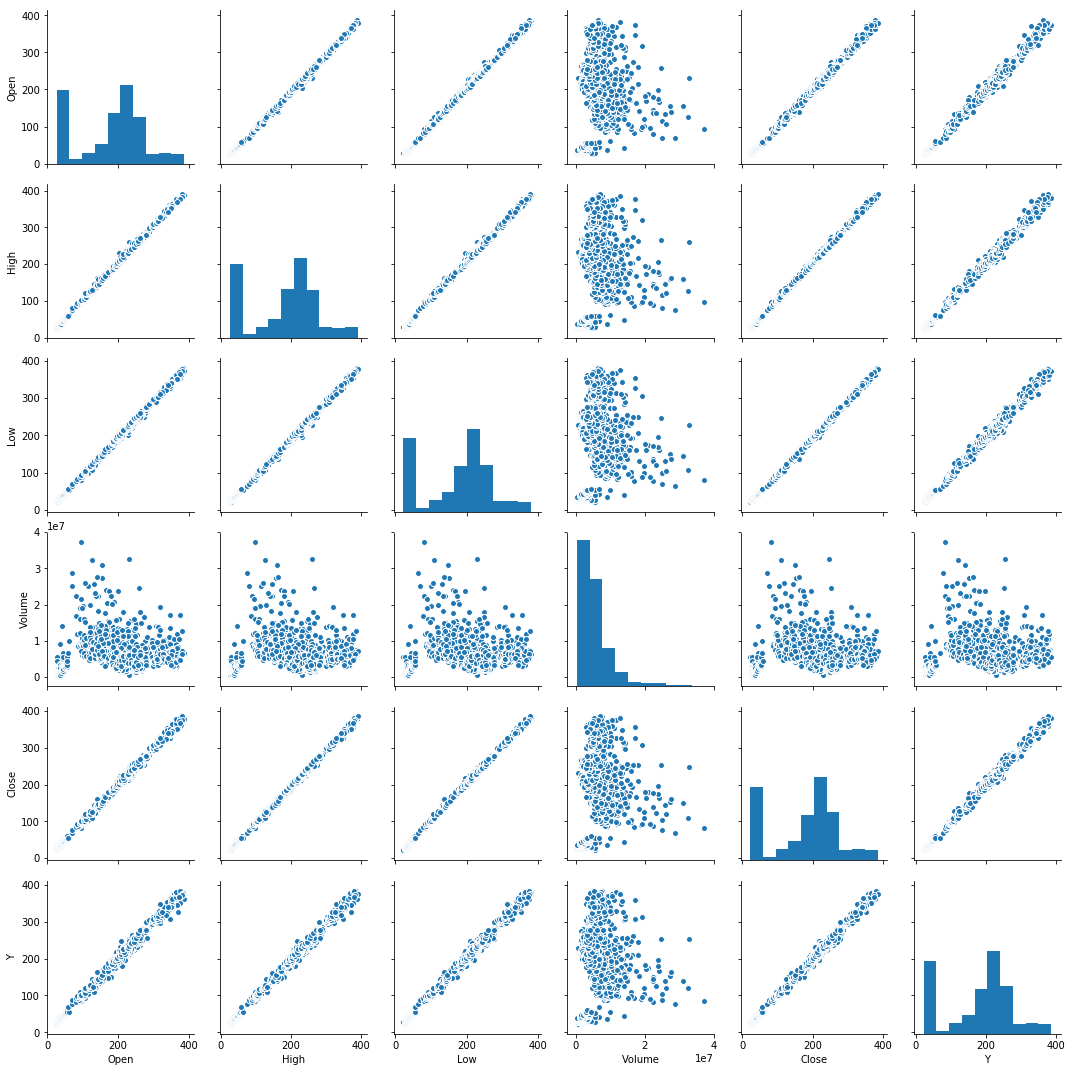

In [10]:
sns.pairplot(df)

In [11]:
df.corr()

,Open,High,Low,Volume,Close,Y
Open,1.000000,0.999502,0.999447,0.274100,0.998887,0.997262
High,0.999502,1.000000,0.999375,0.284416,0.999547,0.997924
Low,0.999447,0.999375,1.000000,0.262157,0.999533,0.997937
Volume,0.274100,0.284416,0.262157,1.000000,0.273147,0.274630
Close,0.998887,0.999547,0.999533,0.273147,1.000000,0.998447
Y,0.997262,0.997924,0.997937,0.274630,0.998447,1.000000


In [12]:
# Checking co-efficient of the data
from sklearn.linear_model import LinearRegression

# create X and y
X = df[columns]
y = df.Y

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print(columns)
print(linreg.coef_)

['Open', 'High', 'Low', 'Volume', 'Close']
[  6.73826594e-02  -2.14118143e-01   2.48442058e-03   1.01461407e-07
   1.14429527e+00]


## Data normalization 
Let's normalize our data for the machine learning algorithms to function better
We will use MinMaxScaler

In [13]:
data = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [14]:
# Split data into train and test scaled_data 
train_size = int(len(scaled_data) * 0.95)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]
print(len(scaled_data), len(train), len(test))
print(scaled_data.shape, train.shape, test.shape)

1445 1372 73
(1445, 6) (1372, 6) (73, 6)


In [15]:
# Split data into features X, and lable y
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X)
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

[[ 0.00644319  0.00730511  0.01404503  0.01530476  0.01460478]
 [ 0.0044158   0.00501709  0.01362452  0.00720672  0.01358327]
 [ 0.00316605  0.00297718  0.01180231  0.01740808  0.01195439]
 ..., 
 [ 0.94703806  0.96248212  0.96428465  0.31095954  0.97501453]
 [ 0.98444745  0.98522443  0.99147765  0.33841952  0.98801801]
 [ 0.96059099  0.96099351  0.96394826  0.27342047  0.97333038]]
(1372, 5) (1372,)
(73, 5) (73,)


## Define the LSTM model parameters

In [16]:
# Reshape input data to 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# Reshape output to 2D 
train_y = train_y.reshape(-1,1)
test_y = test_y.reshape(-1,1)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1372, 1, 5) (1372, 1) (73, 1, 5) (73, 1)


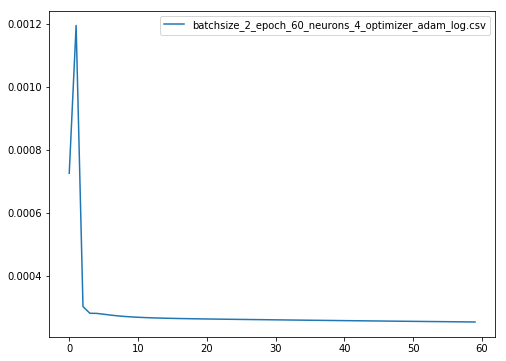

In [31]:
# Parameters for LSTM model
batchsize=2
epoch=60
optimizer='adam'
neurons=4
now = datetime.now().strftime('%Y%m%d_%H%M')
outfile='logs/loss_%s_batchsize_%s_epoch_%s_neurons_%s_optimizer_%s_log.csv' % (now, batchsize, epoch, neurons, optimizer)

# create and fit the LSTM network
csv_logger = CSVLogger(outfile)
model = Sequential()
model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(train_X, train_y, epochs=epoch, batch_size=batchsize, verbose=0 ,shuffle=False, callbacks=[csv_logger] )

# Reading the RMSE losses from the training output file and plot it
rmse_loss= pd.read_csv(outfile)
label="_".join(outfile.split('_')[3:-1])
plt.figure(figsize=(8,6))
plt.plot(rmse_loss.epoch, rmse_loss.loss, label=label)
plt.legend()
plt.show()



In [18]:
# Predict the next day's Close price (Y) for both training and test data
trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)

In [19]:
print(test_X.shape, testPredict.shape)

(73, 1, 5) (73, 1)


## Convert data back to its original format

Example output shape

train_X.shape trainPredict.shape

(352, 1, 5)    (352, 1)


In [20]:
train_X.reshape(len(train_X),train_X.shape[2]).shape

(1372, 5)

In [21]:
def reshape_to_orig(x,y):
    '''
    Merging x and y into its original series shape.
    
    Reshape x from (rows_count,1,cols_count) => (rows_count,cols_count) 
    and concat with y in the shape (rows_count,1)
    For example: (88, 1, 5) + (88, 1) => (88,6)
    
    '''
    return np.hstack((x.reshape(len(x),x.shape[2]), y))

In [22]:
# Calling reshape_to_orig function to reshape both the training aand test data
trainPredict2 = reshape_to_orig(train_X,trainPredict)
trainY2 = reshape_to_orig(train_X,train_y)

testPredict2 = reshape_to_orig(test_X,testPredict)
testY2 = reshape_to_orig(test_X,test_y)

print(trainPredict2.shape, trainY2.shape)
print(testPredict2.shape, testY2.shape)
print(trainPredict2[:3])
print(trainPredict[:3,-1])

(1372, 6) (1372, 6)
(73, 6) (73, 6)
[[ 0.00644319  0.00730511  0.01404503  0.01530476  0.01460478  0.00020583]
 [ 0.0044158   0.00501709  0.01362452  0.00720672  0.01358327 -0.00122014]
 [ 0.00316605  0.00297718  0.01180231  0.01740808  0.01195439 -0.00328304]]
[ 0.00020583 -0.00122014 -0.00328304]


In [23]:
# We have normalized our data before feeding into the model
# Now time to transform it back to the original metrics
trainPredict_orig = scaler.inverse_transform(trainPredict2)
trainY_orig = scaler.inverse_transform(trainY2)

testPredict_orig = scaler.inverse_transform(testPredict2)
testY_orig = scaler.inverse_transform(testY2)

# calculate root mean squared error
trainScore = sqrt(mean_squared_error(trainY_orig[:,-1], trainPredict_orig[:,-1]))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(testY_orig[:,-1], testPredict_orig[:,-1]))
print('Test Score: %.3f RMSE' % (testScore))


Train Score: 13.051 RMSE
Test Score: 10.292 RMSE


In [24]:
print(trainPredict_orig[:3])
trainPredict_orig[:3,-1]

[[  2.89400010e+01   2.95000000e+01   2.76500000e+01   9.28100000e+05
    2.80800000e+01   2.28645539e+01]
 [  2.82099990e+01   2.86700000e+01   2.75000000e+01   6.30100000e+05
    2.77099990e+01   2.23480532e+01]
 [  2.77600000e+01   2.79300000e+01   2.68500000e+01   1.00550000e+06
    2.71200010e+01   2.16008522e+01]]


array([ 22.86455392,  22.3480532 ,  21.60085222])

In [25]:
data.shape, trainPredict_orig.shape[0], testPredict_orig.shape[0]

((1445, 6), 1372, 73)

In [26]:
data[:-1]

array([[  2.89400010e+01,   2.95000000e+01,   2.76500000e+01,
          9.28100000e+05,   2.80800000e+01,   2.77099990e+01],
       [  2.82099990e+01,   2.86700000e+01,   2.75000000e+01,
          6.30100000e+05,   2.77099990e+01,   2.71200010e+01],
       [  2.77600000e+01,   2.79300000e+01,   2.68500000e+01,
          1.00550000e+06,   2.71200010e+01,   2.69100000e+01],
       ..., 
       [  3.53149994e+02,   3.57470001e+02,   3.42880005e+02,
          7.60590000e+06,   3.44989990e+02,   3.45250000e+02],
       [  3.50929993e+02,   3.51239990e+02,   3.40899994e+02,
          7.15630000e+06,   3.45250000e+02,   3.40970001e+02],
       [  3.49899994e+02,   3.51489990e+02,   3.40500000e+02,
          6.06030000e+06,   3.40970001e+02,   3.39600006e+02]])

# Plotting the data
Plotting the train and test data vs the actual next day's Close price

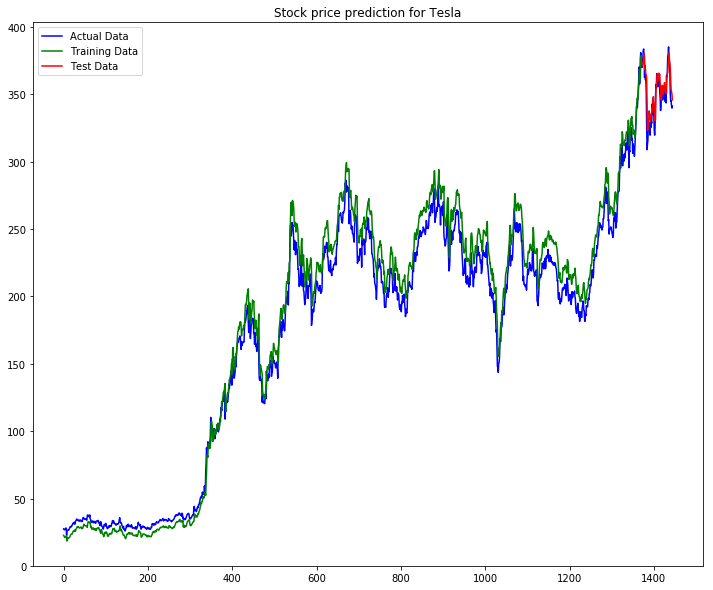

In [27]:
# The actual 'Close' price for next day - actual Y value
data_plot = data[:,-1].reshape(-1,1)

# Predicted Close price for the training data
# The next 2 lines is to arrange the training data as the same sequence order with the actual data
train_plot = np.empty_like(data_plot)
train_plot[:,:] = np.nan
train_plot[:train_size,:] = trainPredict_orig[:,-1].reshape(-1,1)

# Predicted Close price for the test data
# The next 2 lines is to arrange the test data as the same sequence order with the actual data
test_plot = np.empty_like(data_plot)
test_plot[:,:] = np.nan
test_plot[train_size:len(test_plot),:] = testPredict_orig[:,-1].reshape(-1,1)


plt.figure(figsize=(12,10))
plt.plot(data[:,-1], color='blue', label='Actual Data')
plt.plot(train_plot[:,-1], color='green', label='Training Data')
plt.plot(test_plot[:,-1], color='red', label='Test Data')
plt.title('Stock price prediction for Tesla')
plt.legend()
plt.show()

In [28]:
# A quick view of the actual data
data[-10:].shape

(10, 6)

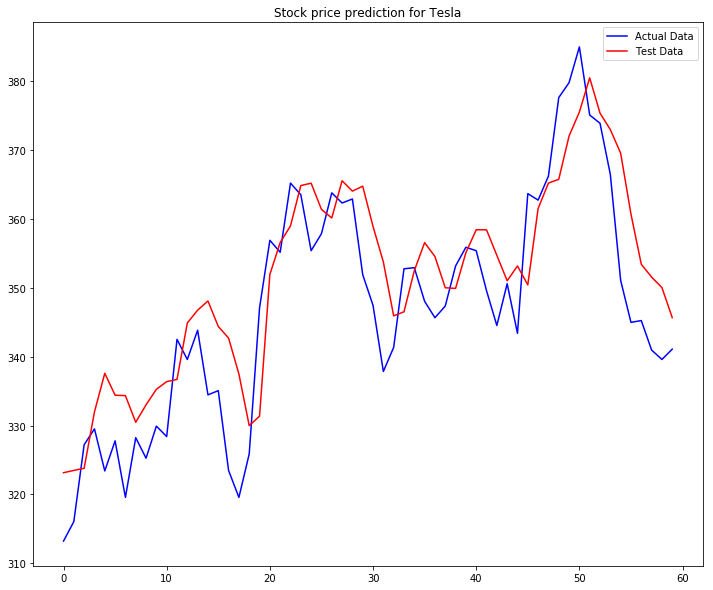

In [30]:
# This is to zoom into the last 60 days of the prediction
plt.figure(figsize=(12,10))
plt.plot(data[-60:,-1], color='blue', label='Actual Data')
plt.plot(test_plot[-60:,-1], color='red', label='Test Data')
plt.title('Stock price prediction for Tesla')
plt.legend()
plt.show()